In [11]:

import os
import re
import glob
import importlib

import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec

import matplotlib as mpl

import utils as util
import plotting as putil
import importlib

import scipy.stats as spstats
import math

In [12]:
putil.set_sns_style(style='dark', min_fontsize=12)

In [13]:
%matplotlib notebook

In [14]:
rootdir = '/mnt/minerva'
# rootdir = '/mnt/sda/Videos'
assay='38mm_dyad'

videodir = os.path.join(rootdir, 'courtship-videos', assay)
sessionpaths = sorted(glob.glob(os.path.join(videodir, '20*')), key=util.natsort)
len(sessionpaths)

# Add FT processed data from AO
if assay == '38mm_dyad':
    addpaths = sorted(glob.glob(os.path.join(videodir, 'AO_data', '*')), key=util.natsort)
sessionpaths.extend(addpaths)
print(len(sessionpaths))

69


In [15]:
ftdir = os.path.join( rootdir, 'free-behavior-analysis/FlyTracker')
savedir = os.path.join(ftdir, assay)

figdir = os.path.join(savedir, 'visualparams')
if not os.path.exists(figdir):
    os.makedirs(figdir)
print(figdir)

/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams


In [16]:
savedir

'/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad'

In [17]:
#sess = [i for i in sessionpaths if '20220212-1150_ctns_3do_sh' in i][0]
no_trk=[]; found_trk=[]; found_sessionpaths=[];
for sess in sessionpaths:
    found_mats = glob.glob(os.path.join(sess, 'visualparams.mat'))
    if len(found_mats)==0:
        no_trk.append(os.path.split(sess)[-1])
    else:
        found_trk.append(os.path.split(sess)[-1])
        found_sessionpaths.append(sess)
print("Found {} of {} mat files.".format(len(found_trk), len(sessionpaths)))
print("No params/feats for {} files.".format(len(no_trk)))

Found 51 of 69 mat files.
No params/feats for 18 files.


In [18]:
d_list = []
for sesspath in found_sessionpaths:
    acq = os.path.split(sesspath)[-1]
    fpath = os.path.join(sesspath, 'visualparams.mat')
    df_ = util.load_mat_frames_and_var(fpath)
    df_['acquisition'] = acq
    # get species
    if 'mel-' in acq:
        species_abbr = 'mel'
        species_strain = 'na'
    elif 'suz-' in acq:
        species_abbr = 'suz'
        species_strain = 'na'
    else:
        if '_fly' in acq:
            species_abbr = acq.split('_')[2]
        else:
            species_abbr = acq.split('_')[1]
        species_strain = 'na'
        if species_abbr.startswith('mau'):
            species_strain = species_abbr[3:]
            species_abbr = species_abbr[0:3]
        elif species_abbr in ('Canton-S', 'ctns'):
            species_abbr = 'mel'
            species_strain = 'cantons'
    # get age
    if '_fly' in acq:
        age = int(re.sub('\D', '', acq.split('_')[3]))
    elif len(acq.split('_'))<2:
        age = None
    else:
        age = int(re.sub('\D', '', acq.split('_')[2]))
    
    df_['species'] = species_abbr
    df_['strain'] = species_strain
    df_['age'] = age
    
    d_list.append(df_)
df = pd.concat(d_list)
print(df.shape)
df.head()

(4022174, 22)


,Time Vector,Angular Position,Angular Size X,Angular Size Y,Angular Area,Angular Velocity,Diff Angular Size X,Diff Angular Size Y,Diff Angular Area,Metric Length X,...,Metric Relative Velocity,Size-to-Speed Ratio X,Size-to-Speed Ratio Y,Target Fly Orientation,Target Fly Major Axis,Target Fly Minor Axis,acquisition,species,strain,age
0,0.033333,77.137872,8.410120,3.834058,25.325078,0.000000,0.000000,0.000000,0.000000,2.196656,...,0.000000,inf,inf,-0.100385,2.200852,0.796680,20191114-1322_fly1_yakWT_3do_AO,yakWT,na,3
1,0.066667,77.405816,8.409527,3.831824,25.308534,1.607662,-0.003560,-0.013406,-0.099266,2.197783,...,0.052303,21.009953,0.351128,-0.120256,2.198671,0.796447,20191114-1322_fly1_yakWT_3do_AO,yakWT,na,3
2,0.100000,77.138749,8.423169,3.833260,25.359090,-1.602399,0.081851,0.008616,0.303334,2.200535,...,-0.033623,-32.723600,-0.546208,-0.131190,2.201425,0.798601,20191114-1322_fly1_yakWT_3do_AO,yakWT,na,3
3,0.133333,77.223982,8.433836,3.834960,25.402462,0.511394,0.064003,0.010197,0.260235,2.202355,...,-0.039759,-27.696282,-0.461912,-0.148901,2.203246,0.794161,20191114-1322_fly1_yakWT_3do_AO,yakWT,na,3
4,0.166667,77.168782,8.444300,3.837469,25.450619,-0.331198,0.062783,0.015054,0.288939,2.203655,...,-0.058631,-18.792487,-0.313232,-0.158881,2.204546,0.797409,20191114-1322_fly1_yakWT_3do_AO,yakWT,na,3


In [19]:
df[['species', 'acquisition']].drop_duplicates().groupby('species').count()

,acquisition
species,
eleWT,24
mel,13
suz,9
yakWT,5


## Load FEAT

In [20]:
importlib.reload(util)

<module 'utils' from '/home/julianarhee/Repositories/flytracker/utils.py'>

In [21]:
feat, trk = util.aggr_feat_mats(found_sessionpaths)

suz-10 1
-- suz None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: suz-10
suz-9 1
-- suz None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: suz-9
suz-8 49345
-- suz None ['m' 'f'] male ID: 0
suz-7 1
-- suz None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: suz-7
suz-6 1
-- suz None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: suz-6
suz-5 1
-- suz None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: suz-5
suz-4 1
-- suz None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: suz-4
suz-3 27487
-- suz None ['m' 'f'] male ID: 0
suz-2 15735
-- suz None ['m' 'f'] male ID: 0
mel-13 24116
-- mel None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: mel-13
mel-12 11062
-- mel None ['m' 'f'] male ID: 0
mel-11 45840
-- mel None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: mel-11
mel-10 25668
-- mel None ['m' 'f'] male ID: 0
Male wing is not >> than female. Check: mel-10
mel-9 6713
-- me

In [22]:
feat[['frame', 'acquisition']].head()                              

,frame,acquisition
0,0,suz-10
1,1,suz-10
2,2,suz-10
3,3,suz-10
4,4,suz-10


In [23]:
trk[['frame', 'acquisition']].head()

,frame,acquisition
0,0,suz-10
1,1,suz-10
2,2,suz-10
3,3,suz-10
4,4,suz-10


In [24]:
#feat_og = feat.copy()
# feat = feat.merge(trk[[ 'wing_l_ang', 'wing_r_ang']], 
#            left_index=True, right_index=True) #, on=['frame', 'sec', 'sex', 'acquisition', 'fpath'])
feat['wing_l_ang'] = trk['wing_l_ang']
feat['wing_r_ang'] = trk['wing_r_ang']

In [25]:
trk.shape, feat.shape

((7689748, 41), (7689748, 26))

In [26]:
# output_dir = '/mnt/minerva/free-behavior-analysis/FlyTracker'
feat_fpath = os.path.join(savedir, 'feat.pkl')
feat.to_pickle(feat_fpath)

trk_fpath = os.path.join(savedir, 'trk.pkl')
trk.to_pickle(trk_fpath)

## Load binary behaviors from Matlab

In [27]:
ftdir = os.path.join( rootdir, 'free-behavior-analysis/FlyTracker')
#basedir = '/mnt/minerva/analysis/FlyTracker'
# matlab_src = '/home/julianarhee/Documents/projects/flytracker-analysis/overviews2/Ddata.mat'
matlab_src = os.path.join(ftdir, 'flytracker-matlab/overviews-%s/Ddata.mat' % assay)
# Set save dir
destdir = os.path.join(ftdir, assay, 'visualparams')
if not os.path.exists(destdir):
    os.makedirs(destdir)
# set FIGID
figid = 'flytracker-matlab/overviews-%s/Ddata.mat, visualparams.mat' % assay
print(destdir)

/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams


In [28]:
behavior_names=['Bilateral Wing Extensions', 'Unilateral Wing Extensions', 'Putative Tap Events', 'Chasing', 'Licking/Proboscis Ext', 'Copulation Attempts', 'Orienting']

In [29]:
#behavior_names=['Bilateral Wing Extensions', 'Unilateral Wing Extensions', 'Putative Tap Events', 'Chasing', 'Licking/Proboscis Ext', 'Copulation Attempts', 'Orienting']
events = util.load_binary_evs_from_mat(matlab_src, feat=feat, behavior_names=behavior_names)
#events = util.add_bout_durations(events)

elegans 20231213-1103_fly1_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231213-1122_fly2_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231213-1154_fly3_eleWT_6do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231213-1212_fly5_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231214-1020_fly1_eleWT_3do_sh_eleWT_3do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231214-1051_fly2_eleWT_3do_sh_eleWT_3do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231214-1127_fly3_eleWT_3do_sh_eleWT_3do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231215-1045_fly1_eleWT_4do_sh_eleWT_3do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231222-1113_fly1_eleWT_4do_sh_eleWT_4do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231222-1149_fly2_eleWT_4do_sh_eleWT_4do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231222-1231_fly3_eleWT_4do_sh_eleWT_4do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231223-1117_fly1_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231223-1136_fly2_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231223-1212_fly3_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231226-1112_fly1_eleWT_4do_sh_eleWT_4do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231226-1137_fly2_eleWT_4do_sh_eleWT_4do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231227-1120_fly1_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231227-1207_fly2_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20231227-1251_fly3_eleWT_5do_sh_eleWT_5do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20240105-1007_fly1_eleWT_3do_sh_eleWT_3do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20240105-1018_fly3_eleWT_3do_sh_eleWT_3do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20240105-1102_fly4_eleWT_3do_sh_eleWT_3do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


elegans 20240109-1348_fly2_eleWT_4do_sh_eleWT_4do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-1


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-10


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-11


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-12


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-13


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-2


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-3


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-4


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-5


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-6


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-7


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-8


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-9


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-10


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-2


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-3


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-4


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-5


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-6


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-7


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-8


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


suzukii suz-9


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


yakuba 20191114-1322_fly1_yakWT_3do_AO


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


yakuba 20191114-1608_fly4_yakWT_3do_AO


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


yakuba 20191115-1157_fly2_yakWT_4do_AO


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


yakuba 20240109-1435_fly3_yakWT_4do_sh_yakWT_4do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


yakuba 20240109-1545_fly4_yakWT_4do_sh_yakWT_4do_gh


/home/julianarhee/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Combine Visual params and Binary events

In [30]:
# Try loading
vparams_fpath = os.path.join(savedir, 'visualparams.pkl')
# vparams_behav = pd.read_pickle(vparams_fpath)

In [32]:
print([a for a, d_ in df.groupby('acquisition') if a not in events['acquisition'].unique()])
# acq = '20220525_Canton-S_age4_m_sh_f_gh_1'
# events[events['acquisition']==acq]

['20240109-1039_fly1_eleWT_4do_sh_eleWT_4do_gh']


In [33]:
curr_acqs = events['acquisition'].unique()
vparams = df[df['acquisition'].isin(curr_acqs)].copy()
vparams = vparams.rename(columns={'Time Vector': 'Time Vector (s)'})
print(vparams.shape, events.shape)

(3844874, 22) (3844874, 42)


In [34]:
vparams_behav = pd.merge(vparams, events, on=['Time Vector (s)', 'acquisition', 'species', 'strain', 'age'])
print(vparams_behav.shape)

(3844874, 59)


In [35]:
df.shape, events.shape, vparams_behav.shape

((4022174, 22), (3844874, 42), (3844874, 59))

In [36]:
# # acq = '20220128-1516_mauR4_4do_gh'
# acq= '20220203-1147_yak_7do_sh'
# #acq='20220301_Canton-S_age5_m_sh_f_gh_1'
# beh_ = vparams_behav[vparams_behav['acquisition']==acq].copy()
# beh_.shape

In [37]:
vparams_behav['Angular Position (rad)'] = np.deg2rad(vparams_behav['Angular Position']) # set range -np.pi, np.pi
vparams_behav['Angular Position (norm)'] = vparams_behav['Angular Position (rad)'] / np.pi # normalize to map to -1, 1
vparams_behav['Metric Relative Velocity (abs)'] = np.abs(vparams_behav['Metric Relative Velocity'])

vparams_behav['Target Fly Orientation (range)']  = [math.remainder(v, 2*np.pi) for v in vparams_behav['Target Fly Orientation']] # set range -np.pi, np.pi

vparams_behav['vel (abs)'] = np.abs(vparams_behav['vel'])
vparams_behav['Angular Size (norm)'] = vparams_behav['Angular Size X'] / 180.
# vparams_behav['Angular Area (norm)'] = vparams_behav['Angular Area'] / 180.

vparams_behav['Angular Velocity (rad)'] = [np.deg2rad(math.remainder(v, 360.)) for v in vparams_behav['Angular Velocity']] # within 360 deg. then in rad
vparams_behav['Angular Velocity (abs)'] = np.abs(vparams_behav['Angular Velocity (rad)'])

vparams_behav['Angular Size (rad)'] = np.deg2rad(vparams_behav['Angular Size X']) # set range -np.pi, np.pi

vparams_behav['ang_vel (rad)'] = np.deg2rad(vparams_behav['ang_vel']) # set range -np.pi, np.pi


In [38]:
vparams_behav['Target Fly Orientation'].min(), vparams_behav['Target Fly Orientation'] .max()

(-6.2798350226061626, 6.278990313306659)

In [39]:
vparams_behav['Angular Velocity (rad)'].min(), vparams_behav['Angular Velocity (rad)'] .max()

(-3.141558084431864, 3.1414461742651616)

In [40]:
vparams_behav['Angular Velocity (abs)'].min(), vparams_behav['Angular Velocity (abs)'] .max()

(0.0, 3.141558084431864)

In [41]:
# save
vparams_fpath = os.path.join(savedir, 'visualparams.pkl')
vparams_behav.to_pickle(vparams_fpath)

# Calculate bouts

In [42]:
m_list = []
for (acq, species), beh_ in vparams_behav.groupby(['acquisition', 'species']):
    if species=='rsim':
        continue
    mean_ = beh_.groupby('boutnum').mean().reset_index()
    mean_['Angular Position'] = beh_.groupby('boutnum')['Angular Position'].apply(spstats.circmean, high=180, low=-180)
    mean_['Angular Position (rad)'] = beh_.groupby('boutnum')['Angular Position (rad)'].apply(spstats.circmean, high=np.pi, low=-np.pi)
    mean_['Angular Velocity (rad)'] = beh_.groupby('boutnum')['Angular Velocity (rad)'].apply(spstats.circmean, high=np.pi, low=-np.pi)
    mean_['Angular Velocity (abs)'] = np.abs(mean_['Angular Velocity (rad)']) #beh_.groupby('boutnum')['Angular Velocity (rad)'].apply(np.abs)

    beh_['Metric Relative Velocity (abs)'] = beh_['Metric Relative Velocity'].abs() #beh_.groupby('boutnum')['Metric Relative Velocity'].apply(np.abs)
    mean_['Metric Relative Velocity (abs)'] = beh_.groupby('boutnum')['Metric Relative Velocity (abs)'].mean()
    mean_['acquisition'] = acq
    mean_['species'] = species
    m_list.append(mean_)
    
bouts = pd.concat(m_list).reset_index(drop=True)

In [43]:
vparams_behav['Angular Position'].min(), vparams_behav['Angular Position'].max()

(-179.99993869345752, 179.99967259804654)

In [44]:
bouts['Angular Velocity (rad)'].min(), bouts['Angular Velocity (rad)'].max()

(-3.0872607835646617, 3.062257119688134)

In [45]:
bouts['Angular Position (rad)'].min(), bouts['Angular Position (rad)'].max()

(-3.14016411362414, 3.1376548948982412)

In [46]:
bouts.groupby(['species'])['Angular Velocity (rad)'].mean()

species
eleWT   -0.001911
mel     -0.022238
suz     -0.008553
yakWT   -0.009087
Name: Angular Velocity (rad), dtype: float64

# Plotting

In [47]:
figdir

'/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams'

In [48]:
# species_list = ['ele', 'yak'] #bouts['species'].unique()
# species_list = ['mel', 'mau', 'yak']
species_list = ['mel', 'yakWT', 'eleWT', 'suz']
species_colors = sns.color_palette('colorblind', n_colors=len(species_list))

In [49]:
behavs2plot = ['Orienting', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions', 'Bilateral Wing Extensions']

In [50]:
species_cdict = dict((k, v) for k, v in zip(species_list, species_colors))

<IPython.core.display.Javascript object>


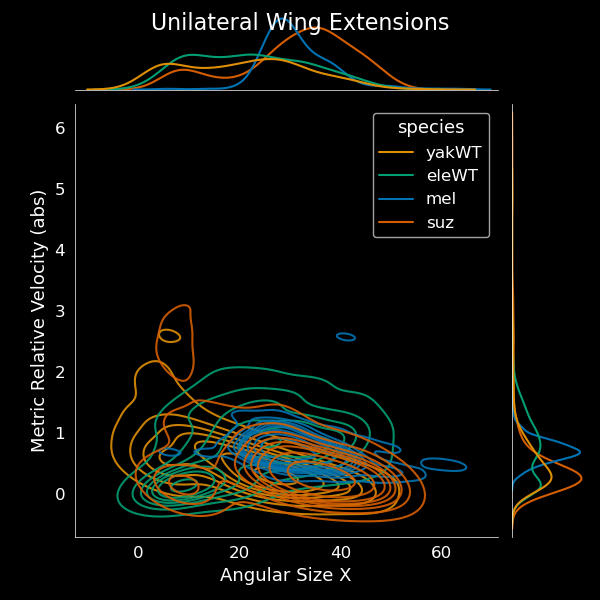

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


Text(0.5, 0.98, 'Unilateral Wing Extensions')

In [58]:
x = 'Angular Size X'
y = 'Metric Relative Velocity (abs)'

curr_species = ['mel', 'yakWT', 'eleWT', 'suz']

behav='Unilateral Wing Extensions'
plotdf = bouts[bouts[behav]>0].copy()
#for curr_species in [['mel', 'eleWT', 'yakWT']]: #[['mau', 'mel'], ['yak', 'sant']]:
plotdf1 = plotdf[plotdf['species'].isin(curr_species)]
g = sns.jointplot(data=plotdf1, x=x, y=y, hue='species', palette=species_cdict,
          kind='kde', joint_kws={'s': 10, 'alpha': 0.9})
g.fig.suptitle(behav)


In [54]:
# fig, axn= pl.subplots(1, len(behavs2plot), figsize=(14,4), subplot_kw={'projection': '3d'}, sharex=True, sharey=True)
# #y = 'Metric Length X' # 'Angular Area'
# #x = 'Metric Distance' #'Angular Position'
# y = 'Angular Size X'
# x = 'Angular Position'
# z = 'Metric Relative Velocity (abs)' #'Angular Velocity'

# for ai, behav in enumerate(behavs2plot):
#     ax=axn[ai]
#     for col, sp in zip(species_colors, species_list):
#         if sp=='sant':
#             continue
#         plotdf = bouts[(bouts['species']==sp) & (bouts[behav]>0)]
#         ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col, alpha=0.5, s=10, label=sp)
#     ax.set_title(behav)
#     if ai == 0:
#         ax.set_xlabel(x)
#         ax.set_ylabel(y)
#         ax.set_zlabel(z)
# ax.legend(bbox_to_anchor=(1,1), loc='upper left')
# pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9)

# putil.label_figure(fig, figid)
# figname = '3d-scatter_x-{}_y-{}_z-{}_{}'.format(x, y, z, 'ele-yak')
# pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))
# print(os.path.join(figdir, '{}.png'.format(figname)))

<IPython.core.display.Javascript object>


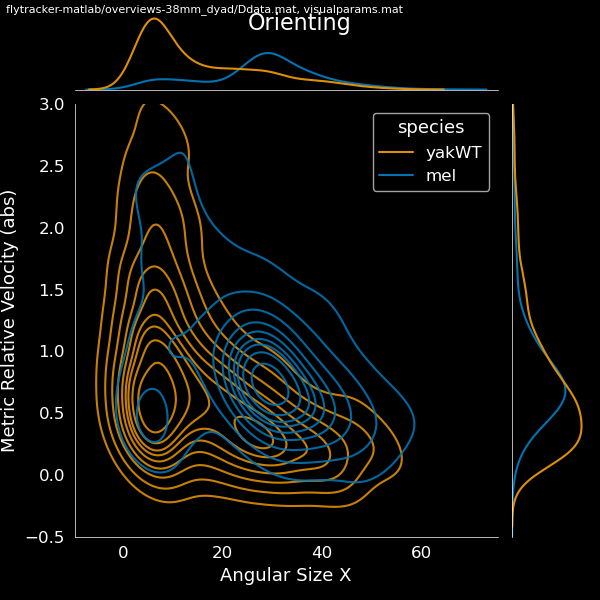

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_Orienting_mel-yakWT.png


<IPython.core.display.Javascript object>


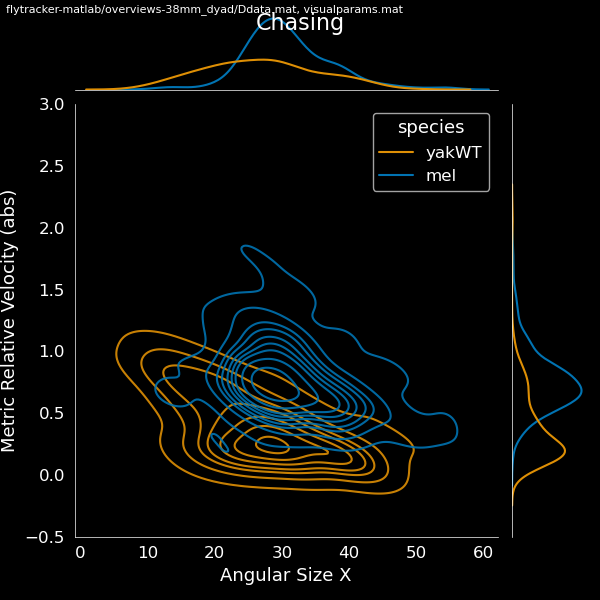

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_Chasing_mel-yakWT.png


<IPython.core.display.Javascript object>


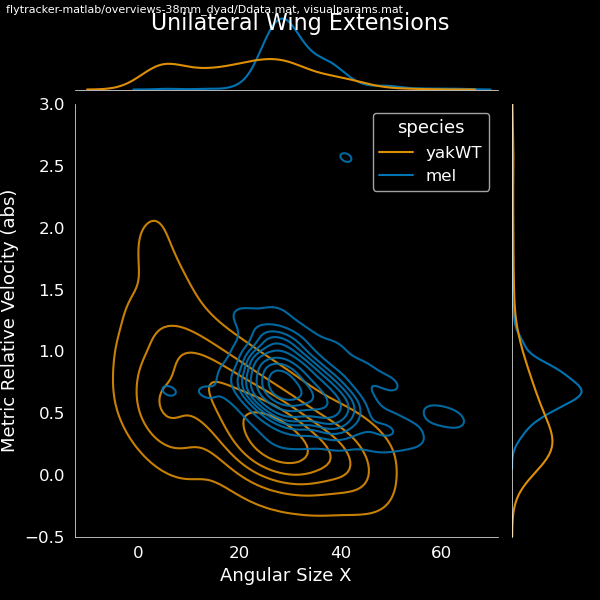

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_Unilateral Wing Extensions_mel-yakWT.png


<IPython.core.display.Javascript object>


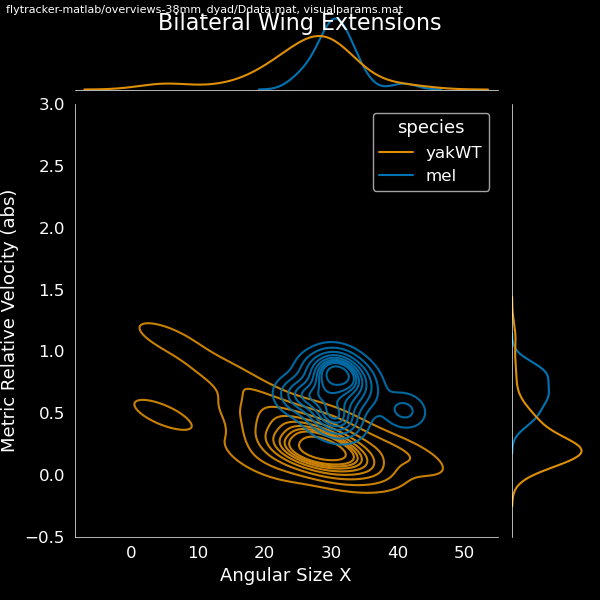

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_Bilateral Wing Extensions_mel-yakWT.png


In [104]:
#fig, ax = pl.subplots(1, 1) #len(behavs2plot), figsize=(12,4), subplot_kw={'projection': '3d'})
#x = 'Angular Position' #'Angular Size X'
#y = 'Metric Length X' #'Angular Position' #'Metric Relative Velocity' 

behavs2plot = ['Orienting', 'Chasing', 'Unilateral Wing Extensions', 'Bilateral Wing Extensions']
# curr_species = ['mel', 'eleWT', 'yakWT']
curr_species = ['mel','yakWT']
x = 'Angular Size X'
y = 'Metric Relative Velocity (abs)'
for behav in behavs2plot:
    plotdf = bouts[bouts[behav]>0].copy()
    #for curr_species in [['mel', 'eleWT', 'yakWT']]: #[['mau', 'mel'], ['yak', 'sant']]:
    plotdf1 = plotdf[plotdf['species'].isin(curr_species)]
    g = sns.jointplot(data=plotdf1, x=x, y=y, hue='species', palette=species_cdict,
              kind='kde', joint_kws={'s': 10, 'alpha': 0.9})
    g.fig.suptitle(behav)
    pl.ylim([-0.5, 3])

    figname = 'joint-{}-{}_{}_{}'.format(x, y, behav, '-'.join(curr_species))

    putil.label_figure(g.fig, figid)
    pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))
    print(os.path.join(figdir, '{}.png'.format(figname)))

<IPython.core.display.Javascript object>


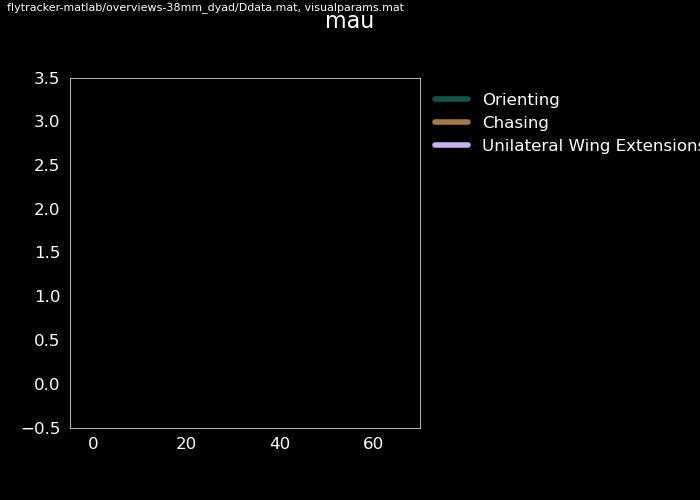

/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_mau_uwe-only.png


<IPython.core.display.Javascript object>


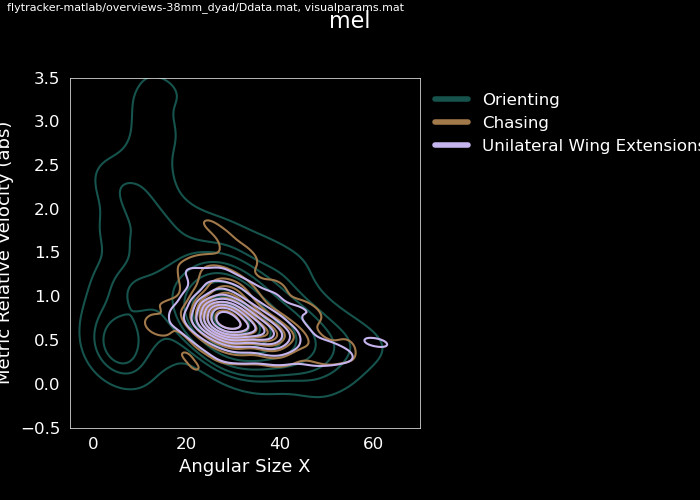

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_mel_uwe-only.png


<IPython.core.display.Javascript object>


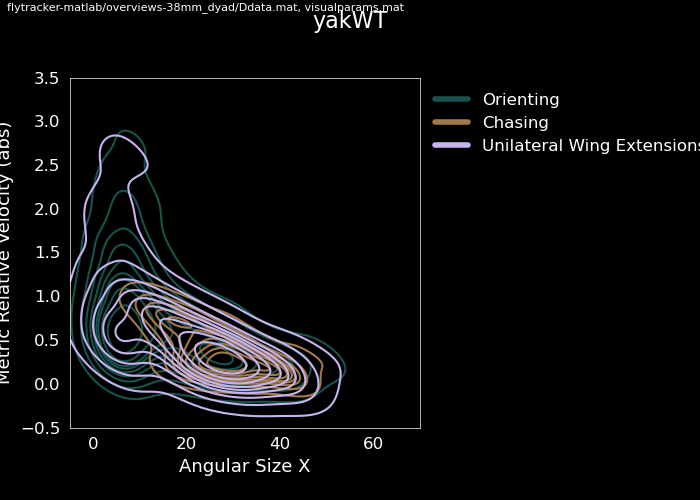

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_yakWT_uwe-only.png


<IPython.core.display.Javascript object>


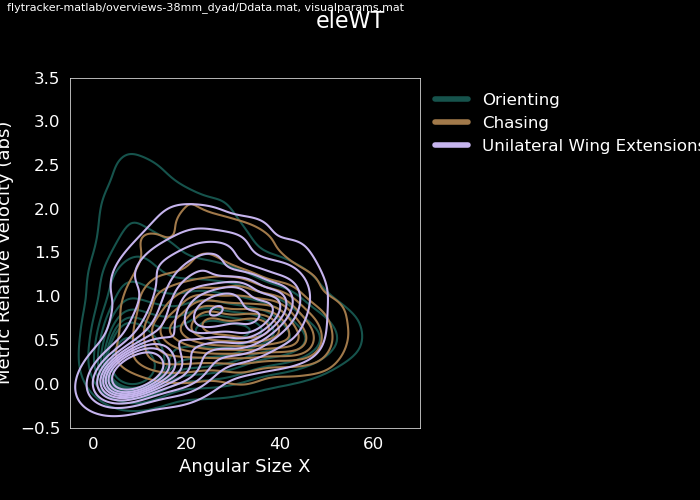

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_eleWT_uwe-only.png


<IPython.core.display.Javascript object>


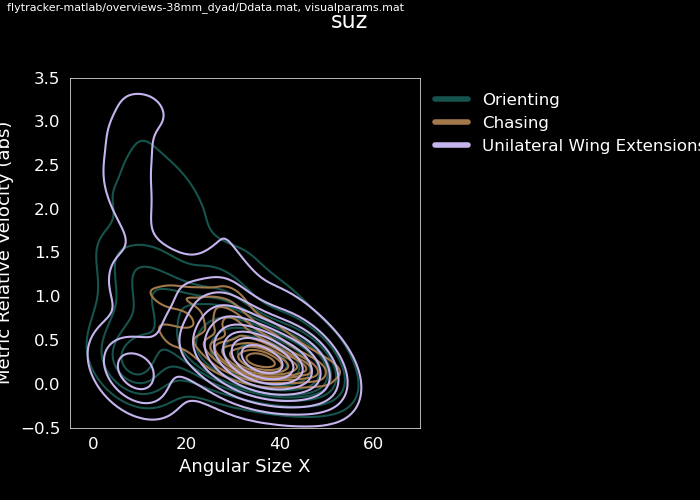

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/joint-Angular Size X-Metric Relative Velocity (abs)_suz_uwe-only.png


In [105]:
#import SeabornFig2Grid as sfg

behavs2plot = ['Orienting', 'Chasing', 'Unilateral Wing Extensions'] #, 'Bilateral Wing Extensions']
behav_colors = sns.color_palette('cubehelix', n_colors=len(behavs2plot))
behav_cdict = dict((k, v) for k, v in zip(behavs2plot, behav_colors))

x = 'Angular Size X'
y = 'Metric Relative Velocity (abs)'

for curr_species in ['mau', 'mel', 'yakWT', 'eleWT', 'suz']: #[['mau', 'mel'], ['yak', 'sant']]:
    plotdf1 = bouts[bouts['species'].isin([curr_species])]
    
    fig, ax = pl.subplots(figsize=(7,5))
    for ai, (col, behav) in enumerate(zip(behav_colors, behavs2plot)):
        plotdf = plotdf1[plotdf1[behav]>0].copy()
        sns.kdeplot(data=plotdf, x=x, y=y, color=col, ax=ax, label=behav,
                        alpha=1, lw=2, legend=1)
    ax.set_box_aspect(1)
    
    legh = putil.custom_legend(behavs2plot, behav_colors)
    ax.legend(handles=legh, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    
    ax.set_xlim([-5, 70]) #np.ceil(bouts[x].max())])
    ax.set_ylim([-0.5, 3.5]) #np.ceil(bouts[y].max())])

    
    pl.subplots_adjust(left=0.1, right=0.6)
    fig.suptitle(curr_species)
    #g.fig.suptitle(behav)
    figname = 'joint-{}-{}_{}_uwe-only'.format(x, y, curr_species)

    putil.label_figure(fig, figid)
    pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))
    print(os.path.join(figdir, '{}.png'.format(figname)))

# Orientation

In [495]:
bouts['acquisition'].unique()

array(['20191114-1322_fly1_yakWT_3do_AO',
       '20191114-1608_fly4_yakWT_3do_AO',
       '20191115-1157_fly2_yakWT_4do_AO',
       '20231213-1103_fly1_eleWT_5do_sh_eleWT_5do_gh',
       '20231213-1122_fly2_eleWT_5do_sh_eleWT_5do_gh',
       '20231213-1154_fly3_eleWT_6do_sh_eleWT_5do_gh',
       '20231213-1212_fly5_eleWT_5do_sh_eleWT_5do_gh',
       '20231214-1020_fly1_eleWT_3do_sh_eleWT_3do_gh',
       '20231214-1051_fly2_eleWT_3do_sh_eleWT_3do_gh',
       '20231215-1045_fly1_eleWT_4do_sh_eleWT_3do_gh',
       '20231222-1113_fly1_eleWT_4do_sh_eleWT_4do_gh',
       '20231222-1149_fly2_eleWT_4do_sh_eleWT_4do_gh',
       '20231222-1231_fly3_eleWT_4do_sh_eleWT_4do_gh',
       '20231223-1117_fly1_eleWT_5do_sh_eleWT_5do_gh',
       '20231223-1136_fly2_eleWT_5do_sh_eleWT_5do_gh',
       '20231223-1212_fly3_eleWT_5do_sh_eleWT_5do_gh',
       '20231226-1112_fly1_eleWT_4do_sh_eleWT_4do_gh',
       '20231226-1137_fly2_eleWT_4do_sh_eleWT_4do_gh',
       '20231227-1120_fly1_eleWT_5do_sh_eleWT_5do

In [622]:
# vparams_behav['Angular Position (rad)'] = np.deg2rad(vparams_behav['Angular Position']) # set range -np.pi, np.pi
# vparams_behav['Angular Position (norm)'] = vparams_behav['Angular Position (rad)'] / np.pi # normalize to map to -1, 1
# vparams_behav['Metric Relative Velocity (abs)'] = np.abs(vparams_behav['Metric Relative Velocity'])

# vparams_behav['Target Fly Orientation (range)']  = [math.remainder(v, 2*np.pi) for v in vparams_behav['Target Fly Orientation']] # set range -np.pi, np.pi

# vparams_behav['vel (abs)'] = np.abs(vp['vel'])
# vparams_behav['Angular Size (norm)'] = vparams_behav['Angular Size X'] / 180.
# # vparams_behav['Angular Area (norm)'] = vparams_behav['Angular Area'] / 180.

# vparams_behav['Angular Velocity (rad)'] = [np.deg2rad(math.remainder(v, 360.)) for v in vparams_behav['Angular Velocity']] # within 360 deg. then in rad
# vparams_behav['ang_vel (rad)'] = np.deg2rad(vparams_behav['ang_vel']) # set range -np.pi, np.pi


In [60]:
acq = '20191114-1608_fly4_yakWT_3do_AO' #'20191114-1322_fly1_yakWT_3do_AO' #'20231213-1103_fly1_eleWT_5do_sh_eleWT_5do_gh'
b_ = bouts[(bouts['acquisition']==acq) & (bouts['Disengaged']==0)].copy()
b_.shape
vp = vparams_behav[(vparams_behav['acquisition']==acq) ].copy() #& (vparams_behav['Disengaged']==0)].copy()

Female orientation relative to male: 
Convert range from matlab array to -np.pi, np.pi (math.remainder). 
Set both legend and axis to "N" or "E" -- should be correct!

<IPython.core.display.Javascript object>


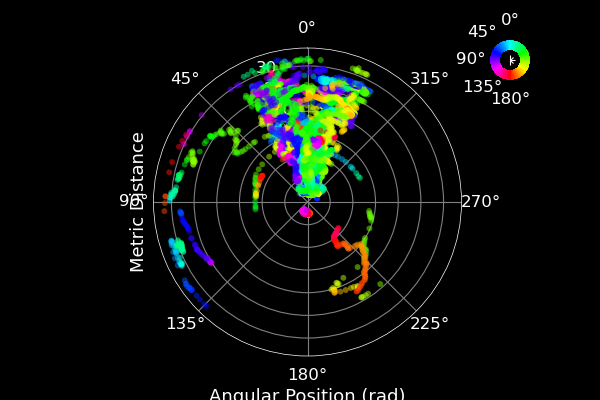

<PolarAxes:>

In [61]:
ix = 9202#7087: 90 (prple) #9202: 0 (green) #10260: 135 #11000: 45
hue_min=-np.pi
hue_max = np.pi
hue_norm = mpl.colors.Normalize(hue_min, hue_max)
fig, ax = pl.subplots(subplot_kw={'projection': 'polar'})
# sns.scatterplot(x='Angular Position (rad)', y='Metric Distance', ax=ax,
# #                 data=vp[(vp['Disengaged']==0) & (vp['frame']==ix)], 
#                 data=vp[ (vp['frame']==ix)], 
#                 hue='Target Fly Orientation (range)', hue_norm=hue_norm, palette='hsv',
#                 alpha=1, size=2, edgecolor='none', legend=0)
sns.scatterplot(x='Angular Position (rad)', y='Metric Distance', data=vp[vp['Disengaged']==0], ax=ax,
                hue='Target Fly Orientation (range)', hue_norm=hue_norm, palette='hsv',
                alpha=0.5, size=2, edgecolor='none', legend=0)
ax.set_theta_zero_location("N")
putil.add_colorwheel(fig, plot_ring=True, theta_range=[hue_min, hue_max], north=True)

In [72]:
'duration' in bouts.columns

bouts = util.add_bout_durations(bouts)


In [84]:
bouts['duration'] = bouts['boutdur'] * 1000

<IPython.core.display.Javascript object>


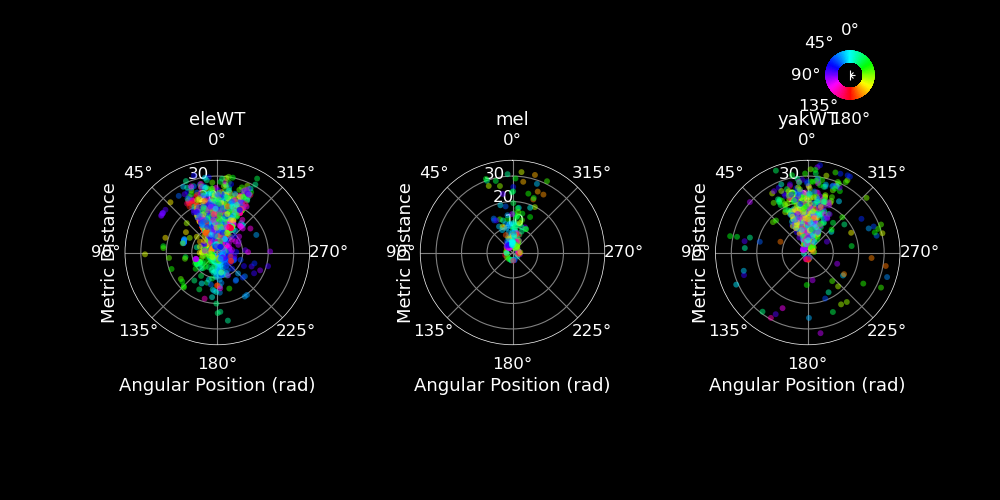

In [85]:
hue_min=-np.pi
hue_max = np.pi
hue_norm = mpl.colors.Normalize(hue_min, hue_max)

fig, axn = pl.subplots(1, len(curr_species), subplot_kw={'projection': 'polar'}, figsize=(10,5), sharex=True, sharey=True)

for i, (sp, b_) in enumerate(bouts[bouts['species'].isin(curr_species)].groupby('species')):
    ax=axn[i]
    sns.scatterplot(x='Angular Position (rad)', y='Metric Distance', data=b_[b_['Disengaged']==0], ax=ax,
                    hue='Target Fly Orientation (range)', hue_norm=hue_norm, palette='hsv',
                    size='duration',
                    alpha=0.5,  edgecolor='none', legend=0)
    ax.set_theta_zero_location("N")
    ax.set_title(sp)
putil.add_colorwheel(fig, plot_ring=True, theta_range=[hue_min, hue_max], north=True)

pl.subplots_adjust(wspace=0.6)

# Models

In [51]:
import math
import copy

In [433]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error,PredictionErrorDisplay
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
import scipy as sp

from sklearn.model_selection import RepeatedKFold, cross_validate, cross_val_score

In [56]:
import sklearn

In [57]:
sklearn.__version__

'1.3.2'

In [58]:
# !pip install sklearn --upgrade

# MLR

In [583]:
curr_figdir = os.path.join(figdir, 'models')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print(curr_figdir)

/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/models


In [717]:
acq = 'mel-1' #'20191115-1157_fly2_yakWT_4do_AO' #'suz-4' #20191114-1608_fly4_yakWT_3do_AO' #'20191114-1322_fly1_yakWT_3do_AO' #'20231213-1103_fly1_eleWT_5do_sh_eleWT_5do_gh'
# b_ = bouts[(bouts['acquisition']==acq) & (bouts['Disengaged']==0)].copy()
# b_.shape

curr_sp = 'mel'

vp = vparams_behav[(vparams_behav['species']==curr_sp) ].copy() #& (vparams_behav['Disengaged']==0)].copy()

xvars = ['Metric Distance', 'Angular Position (norm)', 'Angular Size (norm)', 'Angular Velocity (rad)', 'Target Fly Orientation']
xvars = [str(s) for s in xvars]
yvars = ['vel'] #, 'ang_vel (rad)', 'wing_l_ang', 'wing_r_ang'] # 'Bilateral Wing Extensions'] #,'Unilateral Wing Extensions'] # 'Metric Relative Velocity (abs)']
units = 'mm/s'

allvars = copy.copy(xvars)
allvars.extend(yvars)
inputdata = vp[vp['Disengaged']==0][allvars].dropna().copy()

X = inputdata[xvars]
X.columns = X.columns.astype(str)
y = inputdata[yvars]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [718]:
X.columns.astype(str)

Index(['Metric Distance', 'Angular Position (norm)', 'Angular Size (norm)',
       'Angular Velocity (rad)', 'Target Fly Orientation'],
      dtype='object')

In [719]:
# train_dataset = X_train.copy()
# train_dataset.insert(0, "vel", y_train)
# _ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [720]:
inputdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393822 entries, 2755274 to 3196714
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Metric Distance          393822 non-null  float64
 1   Angular Position (norm)  393822 non-null  float64
 2   Angular Size (norm)      393822 non-null  float64
 3   Angular Velocity (rad)   393822 non-null  float64
 4   Target Fly Orientation   393822 non-null  float64
 5   vel                      393822 non-null  float64
dtypes: float64(6)
memory usage: 21.0 MB


In [721]:
model_type = 'LinearRegression'
# PIPELINE
categorical_columns=[]
numerical_columns = X.select_dtypes(include='number').columns.tolist()

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression() #alpha=1e-10) #, func=np.log10, inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  []),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Metric Distance',
                                                   'Angular Position (norm)',
                                                   'Angular Size (norm)',
                                                   'Angular Velocity (rad)',
                                                   'Target Fly '
                                                   'Orientation'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LinearRegression()))])

In [722]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
# scores = {
#     "Med.Abs.Err. training set": f"{mae_train:.2f} {units}",
#     "Med.Abs.Err. testing set": f"{mae_test:.2f} {units}",
# }

r2_test = r2_score(y_test, y_pred)
mean_ae_test = mean_absolute_error(y_test, y_pred)
scores = {
    #"Med Abs.Err. testing set": f"{mae_test:.2f} {units}",
    "Mean Abs.Err. testing set": f"{mean_ae_test:.2f} {units}",
    "R2 testing set": f"{r2_test:.2f}",
}

# model evaluation 
print('mean_squared_error : ', mean_squared_error(y_test, y_pred)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred)) 
print('r2 score : ', r2_score(y_test, y_pred)) # best is 1 (can be neg if rly bad)


mean_squared_error :  25.42131448602514
mean_absolute_error :  3.8271070193395587
r2 score :  0.21737165157728056


<IPython.core.display.Javascript object>


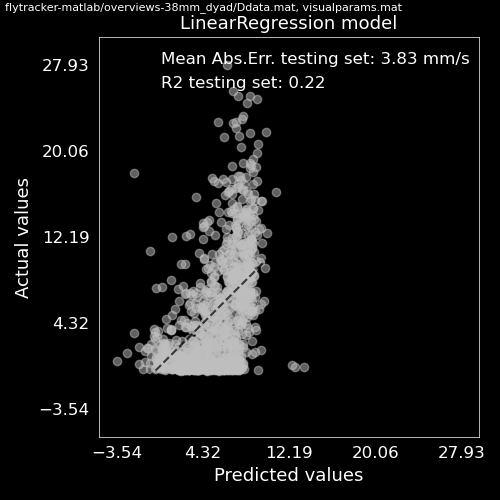

LinearRegression-pred-v-true_mel


In [723]:
_, ax = pl.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test.values, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={'color': [0.75]*3 ,"alpha": 0.5}
)
ax.set_title("{} model".format(model_type))
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left", frameon=False)
pl.tight_layout()
ax.set_aspect(1)
fig = ax.figure

putil.label_figure(fig, figid)
figname = '{}-pred-v-true_{}'.format(model_type, curr_sp)

pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))
print(figname)

In [725]:
feature_names = xvars #model.get_feature_names_out()

coefs = pd.DataFrame(model[-1].regressor_.coef_, columns=["Coefficients"], index=feature_names)
coefs

,Coefficients
Metric Distance,0.318717
Angular Position (norm),-0.292613
Angular Size (norm),-2.542081
Angular Velocity (rad),0.046801
Target Fly Orientation,0.102193


In [726]:
## Compare with and without preprocessing/scaling
# ------------------------------------------------
# X_train_preprocessed = pd.DataFrame(
#     X_train, columns=feature_names
# )
# fig, axn = pl.subplots(1, 2, sharey=True, sharex=True, figsize=(12,6))
# ax=axn[0]
# X_train_preprocessed.std(axis=0).plot.barh(ax=ax) #figsize=(6,5))
# fig.suptitle('Coefficient Importance')
# ax.set_xlabel("Std. dev. of feature values")
# pl.axvline(x=0, color=".5")

# # adjust 
# coefs = pd.DataFrame(
#     model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
#     columns=["Coefficient importance"],
#     index=feature_names)
# ax=axn[1]
# coefs.plot(kind="barh", ax=ax) #figsize=(8, 5))
# ax.set_xlabel("Coef. values corrected by the feature's std. dev.")
# #pl.title("Ridge model, small regularization")
# ax.legend_.remove()
# pl.axvline(x=0, color=".5")

# pl.subplots_adjust(left=0.2)

## cross-validate

In [727]:
# X_preprocessed = scaler.transform(X)

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    np.array([
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ]).squeeze(),
    columns=feature_names,
)

In [728]:
# cross_val_score(model, X, y, cv=cv)
scores = cross_validate(model, X, y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'explained_variance'),
                        return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df['species'] = curr_sp

scores_df

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_explained_variance,train_explained_variance,species
0,0.023981,0.009121,0.223792,0.221780,-25.502053,-25.462633,-3.830937,-3.831162,0.223810,0.221780,mel
1,0.027214,0.009161,0.223640,0.221817,-25.319407,-25.508454,-3.829872,-3.833676,0.223649,0.221817,mel
2,0.028193,0.009450,0.222119,0.222202,-25.451181,-25.475335,-3.823151,-3.833184,0.222119,0.222202,mel
3,0.027355,0.009231,0.218862,0.223014,-25.533507,-25.454741,-3.840871,-3.830090,0.218869,0.223014,mel
4,0.022869,0.007804,0.222288,0.222152,-25.553281,-25.450061,-3.833483,-3.829717,0.222288,0.222152,mel
5,0.022828,0.007656,0.219519,0.222844,-25.448024,-25.476261,-3.824886,-3.832428,0.219519,0.222844,mel
6,0.023340,0.007716,0.221555,0.222337,-25.421643,-25.482720,-3.818147,-3.835409,0.221567,0.222337,mel
7,0.022879,0.007708,0.223952,0.221735,-25.680674,-25.417959,-3.846953,-3.827429,0.223964,0.221735,mel
8,0.022981,0.007928,0.221618,0.222330,-25.354901,-25.499291,-3.830985,-3.831626,0.221618,0.222330,mel
9,0.022885,0.007864,0.224082,0.221707,-25.451806,-25.475258,-3.837214,-3.830962,0.224082,0.221707,mel


<IPython.core.display.Javascript object>


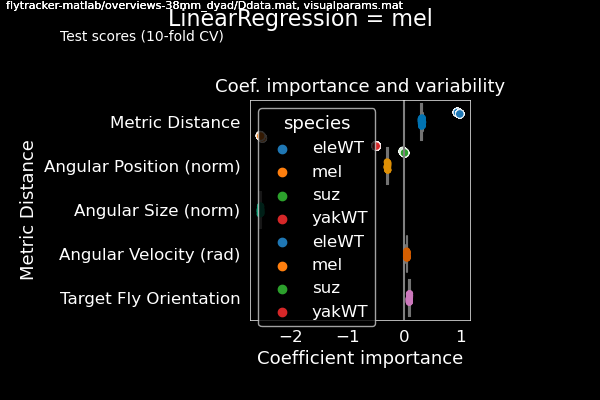

LinearRegression-test-scores_m-e-l


In [729]:
bg_color=[0.75]*3
fig, ax = pl.subplots(figsize=(6, 4))
sns.stripplot(data=coefs, orient="h", palette='colorblind', alpha=1, ax=ax) # "dark:k"
sns.boxplot(data=coefs, orient="h", color=bg_color, saturation=1, whis=10, ax=ax)
ax.set_box_aspect(1)
ax.axvline(x=0, color=".5")
ax.set_xlabel("Coefficient importance")
ax.set_title("Coef. importance and variability")
pl.suptitle("{} = {}".format(model_type, curr_sp))
pl.subplots_adjust(left=0.3, bottom=0.2, top=0.75)


fig.text( 0.1, 0.9, 'Test scores (10-fold CV)')
putil.label_figure(fig, figid)

figname = '{}-test-scores_{}'.format(model_type, '-'.join(curr_sp))
pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))
print(figname)

In [667]:
# acq = 'mel-1' #'20191115-1157_fly2_yakWT_4do_AO' #'suz-4' #20191114-1608_fly4_yakWT_3do_AO' #'20191114-1322_fly1_yakWT_3do_AO' #'20231213-1103_fly1_eleWT_5do_sh_eleWT_5do_gh'
# # b_ = bouts[(bouts['acquisition']==acq) & (bouts['Disengaged']==0)].copy()
# # b_.shape

# curr_sp ='yakWT'
# vp = vparams_behav[(vparams_behav['species']==curr_sp) ].copy() #& (vparams_behav['Disengaged']==0)].copy()

# xvars = ['Metric Distance', 'Angular Position (norm)', 'Angular Size (norm)', 'Angular Velocity (rad)', 'Target Fly Orientation']
# xvars = [str(s) for s in xvars]
# yvars = ['vel'] #, 'ang_vel (rad)', 'wing_l_ang', 'wing_r_ang'] # 'Bilateral Wing Extensions'] #,'Unilateral Wing Extensions'] # 'Metric Relative Velocity (abs)']
# units = 'mm/s'

# allvars = copy.copy(xvars)
# allvars.extend(yvars)
# inputdata = vp[vp['Disengaged']==0][allvars].dropna().copy()

# X = inputdata[xvars]
# X.columns = X.columns.astype(str)
# y = inputdata[yvars]

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

# # PIPELINE
# categorical_columns=[]
# numerical_columns = X.select_dtypes(include='number').columns.tolist()

# preprocessor = make_column_transformer(
#     (OneHotEncoder(drop="if_binary"), categorical_columns),
#     (StandardScaler(), numerical_columns),
# )

# model = make_pipeline(
#     preprocessor,
#     TransformedTargetRegressor(
#         regressor= Ridge() #PLSRegression() ##LinearRegression() #alpha=1e-10) #, func=np.log10, inverse_func=sp.special.exp10
#     ),
# )
# model.fit(X_train, y_train)

# aggregate

In [730]:

xvars = ['Metric Distance', 'Angular Position (norm)', 'Angular Size (norm)', 'Angular Velocity (rad)', 'Target Fly Orientation']
xvars = [str(s) for s in xvars]
yvars = ['vel'] #, 'ang_vel (rad)', 'wing_l_ang', 'wing_r_ang'] # 'Bilateral Wing Extensions'] #,'Unilateral Wing Extensions'] # 'Metric Relative Velocity (abs)']
units = 'mm/s'

allvars = copy.copy(xvars)
allvars.extend(yvars)

c_list = []    
scores_list=[]
for model_type in ['Ridge', 'LinearRegression', 'PLSRegression']:
    for sp, vp in vparams_behav.groupby(['species']): #, 'acquisition']):

        inputdata = vp[vp['Disengaged']==0][allvars].dropna().copy()

        X = inputdata[xvars]
        X.columns = X.columns.astype(str)
        y = inputdata[yvars]

        # split train/test
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

        # PIPELINE
        categorical_columns=[]
        numerical_columns = X.select_dtypes(include='number').columns.tolist()

        preprocessor = make_column_transformer(
            (OneHotEncoder(drop="if_binary"), categorical_columns),
            (StandardScaler(), numerical_columns),
        )
        # Fit
        if model_type=='Ridge':
            curr_model = Ridge()
        elif model_type=='Lasso':
            curr_model = Lasso()
        elif model_type=='PLSRegression':
            curr_model = PLSRegression()
        elif model_type=='LinearRegression':
            curr_model = LinearRegression()

        model = make_pipeline(
            preprocessor,
            TransformedTargetRegressor(
                regressor=curr_model #alpha=1e-10) #, func=np.log10, inverse_func=sp.special.exp10
            ),
        )
        model.fit(X_train, y_train)

        # Get coefs
        feature_names = xvars #model.get_feature_names_out()
        #coefs = pd.DataFrame(model[-1].regressor_.coef_, columns=["Coefficients"], index=feature_names)
        cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=0)
        cv_model = cross_validate(
            model,
            X,
            y,
            cv=cv,
            return_estimator=True,
            n_jobs=2,
        )
        coefs = pd.DataFrame(
            np.array([
                est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
                for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
            ]).squeeze(),
            columns=feature_names,
        )

        coefs['species'] = sp
        #coefs['acquisition'] = acq
        coefs['n_pairs'] = vp['acquisition'].nunique()
        coefs['model'] = model_type
        c_list.append(coefs)

        # cross_val_score(model, X, y, cv=cv)
        scores = cross_validate(model, X, y, cv=cv,
                                scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'explained_variance', 'neg_root_mean_squared_error', ),
                                return_train_score=True)
        scores_df = pd.DataFrame(scores)
        scores_df['species'] = sp
        scores_df['model'] = model_type
        scores_list.append(scores_df)
        #print(coefs.shape)
coefdf = pd.concat(c_list, axis=0)
coefdf.head()
scoresdf = pd.concat(scores_list, axis=0)

In [536]:
neg_scorings = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
for metric in neg_scorings:
    for cond in ['train', 'test']:
        score_name = metric.split('neg_')[-1]
        svar = '{}_{}'.format(cond, metric)
        scoresdf['{}_{}'.format(cond, score_name)] = abs(scoresdf[svar])

<IPython.core.display.Javascript object>


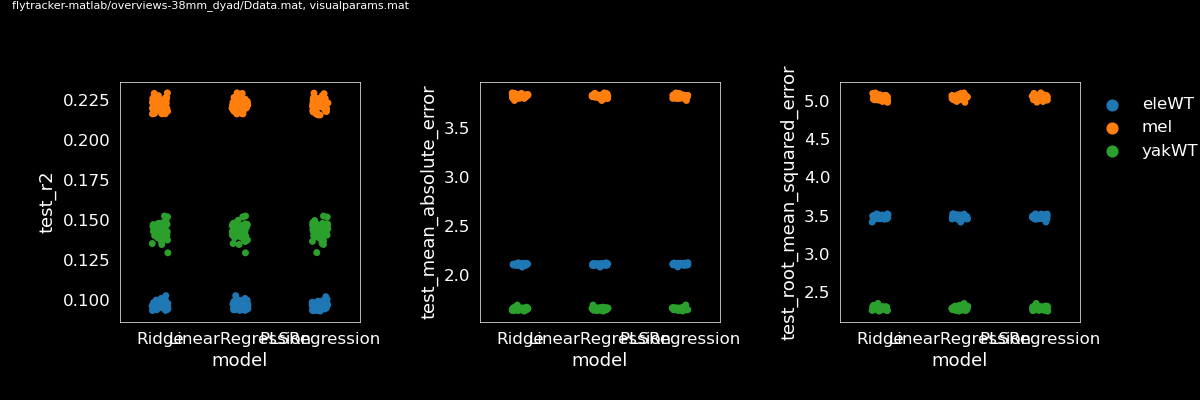

In [555]:
# model_type = 'Ridge'
curr_species = ['mel', 'yakWT', 'eleWT']
curr_scoresdf = scoresdf[scoresdf['species'].isin(curr_species)]
scoring = ['r2', 'mean_absolute_error', 'root_mean_squared_error'] #, 'explained_variance']
#for model_type, plotdf in scoresdf.groupby('model'):
#plotdf = scoresdf[scoresdf['model']=='Ridge']
fig, axn = pl.subplots(1, len(scoring), figsize=(12,4))
#for sp, scores_ in scoresdf.groupby('species'):
for ci, metric in enumerate(scoring):
    cond = 'test'
    ax=axn[ci]
    sns.stripplot(data=curr_scoresdf, x='model', y='{}_{}'.format(cond, metric), hue='species', ax=ax)
    if ci==len(scoring)-1:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()
    ax.set_box_aspect(1)
    
pl.subplots_adjust(left=0.1, wspace=0.5, right=0.9)
putil.label_figure(fig, figid)

'/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams'

<IPython.core.display.Javascript object>


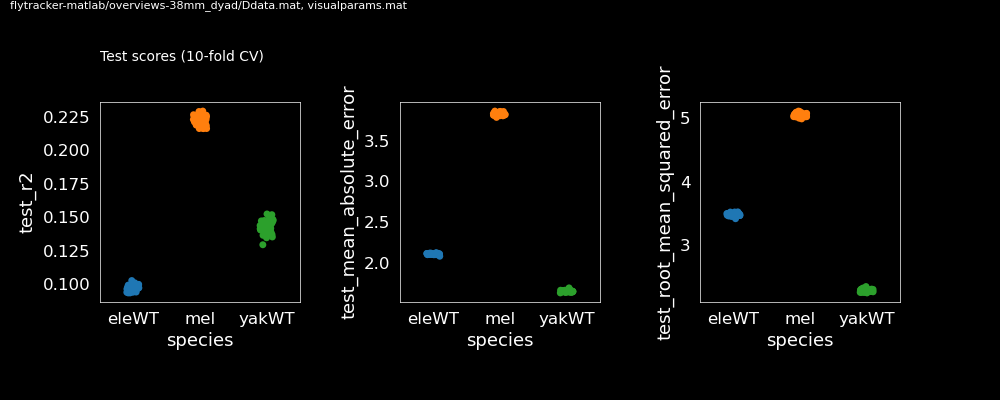

In [558]:
# model_type = 'Ridge'
curr_species = ['mel', 'yakWT', 'eleWT']
model_type = 'LinearRegression'
curr_scoresdf = scoresdf[(scoresdf['species'].isin(curr_species)) & (scoresdf['model']==model_type)]

scoring = ['r2', 'mean_absolute_error', 'root_mean_squared_error'] #, 'explained_variance']
#for model_type, plotdf in scoresdf.groupby('model'):
#plotdf = scoresdf[scoresdf['model']=='Ridge']
fig, axn = pl.subplots(1, len(scoring), figsize=(10,4))
#for sp, scores_ in scoresdf.groupby('species'):
for ci, metric in enumerate(scoring):
    cond = 'test'
    ax=axn[ci]
    sns.stripplot(data=curr_scoresdf, x='species', y='{}_{}'.format(cond, metric), hue='species', ax=ax)
#     if ci==len(scoring)-1:
#         ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
#     else:
    ax.legend_.remove()
    ax.set_box_aspect(1)
    
pl.subplots_adjust(left=0.1, wspace=0.5, right=0.9)

fig.text( 0.1, 0.85, 'Test scores (10-fold CV)')
putil.label_figure(fig, figid)

figname = '{}-test-scores_{}'.format(model_type, '-'.join(curr_species))
pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))


'0.11.1'

In [396]:
# coef_melt = pd.melt(coefdf, id_vars=['species', 'acquisition', 'n_pairs'], 
#         value_vars=feature_names, var_name='feature', value_name='value')

<IPython.core.display.Javascript object>


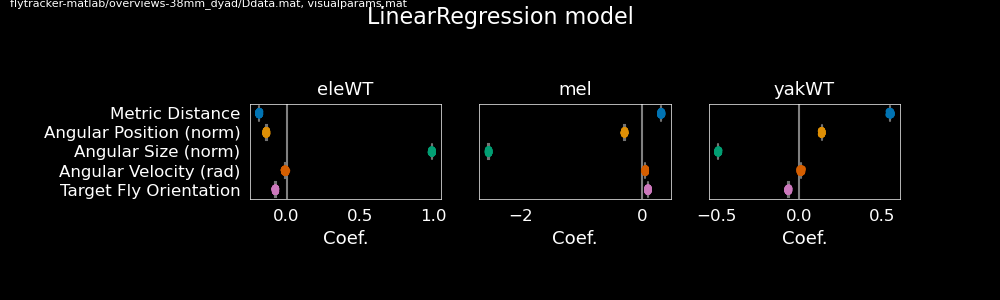

<IPython.core.display.Javascript object>


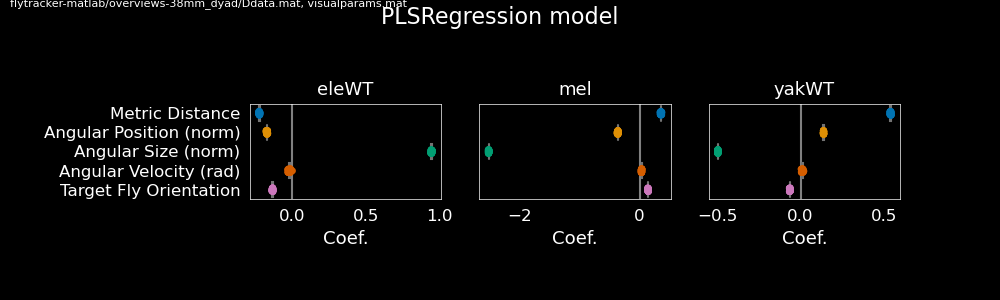

<IPython.core.display.Javascript object>


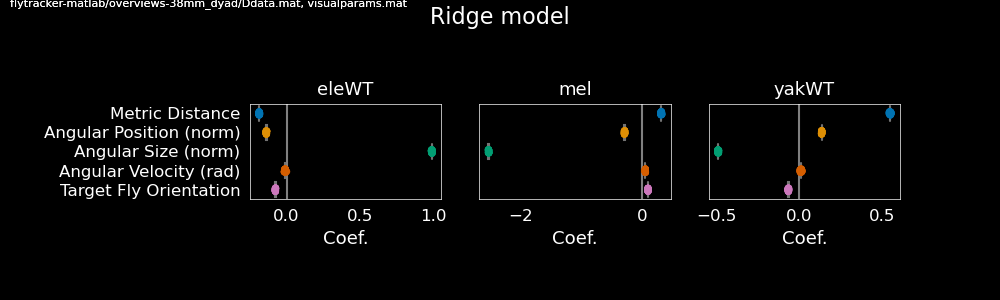

In [582]:
bg_color=[0.75]*3
curr_species = ['mel', 'yakWT', 'eleWT']

# model_type = 'Ridge'
plotdf = coefdf[coefdf['model']==curr_model].copy()
for model_type, plotdf in coefdf.groupby('model'):
    fig, axn = pl.subplots(1, len(curr_species), figsize=(10, 3), sharey=True)
    for ai, (sp, coefs) in enumerate(plotdf[plotdf['species'].isin(curr_species)].groupby('species')):
        ax=axn[ai]
        sns.stripplot(data=coefs[feature_names], orient="h", palette='colorblind', alpha=1, ax=ax) # "dark:k"
        sns.boxplot(data=coefs[feature_names], orient="h", color=bg_color, saturation=1, whis=10, ax=ax)
        #sns.stripplot(data=coefs, x='value', y='feature', hue='acquisition', orient="h", palette='colorblind', alpha=1, ax=ax) # "dark:k"
        #sns.boxplot(data=coefs, x='value', y='feature', orient="h", palette='colorblind', ax=ax) # "dark:k"
        ax.axvline(x=0, color=".5")
        ax.set_xlabel("Coef.")
        ax.set_title(sp) #"Coefficient importance and its variability")
        ax.set_box_aspect(.5)
        #ax.legend_.remove()
    pl.suptitle("{} model".format(model_type))
    pl.subplots_adjust(left=0.25, right=0.9)

    putil.label_figure(fig, figid)

    figname = '{}-coef-weights_{}'.format(model_type, '-'.join(curr_species))
    pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))


## check co-varying features

In [733]:
model_type = 'LinearRegression'

<IPython.core.display.Javascript object>


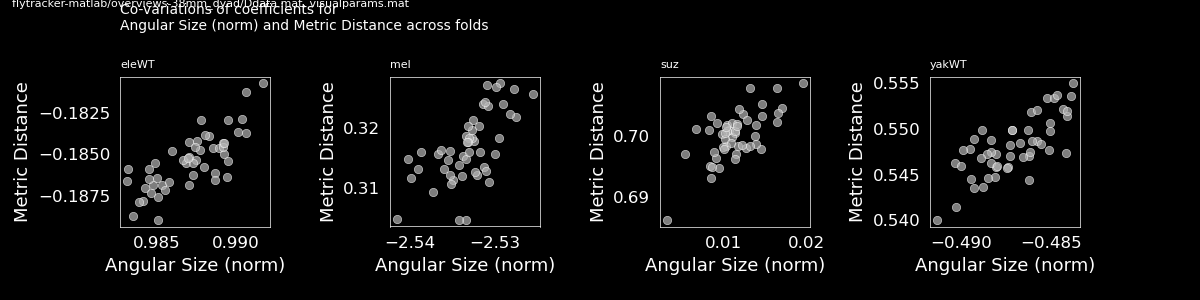

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

In [757]:
var1 = 'Angular Size (norm)'
var2 = 'Metric Distance'
fig, axn = pl.subplots(1, len(curr_sp)+1, figsize=(12, 3))
# pl.ylabel("{} coefficient".format(var1))
# pl.xlabel("{} coefficient".format(var2))
# pl.grid(True)
# pl.xlim(-0.4, 0.5)
# pl.ylim(-0.4, 0.5)
#pl.scatter(coefs[var2], coefs[var1])
for ai, (sp, df_) in enumerate(coefdf[(coefdf['model']==model_type)].groupby('species')):
    ax=axn[ai]
    sns.scatterplot(data=df_, x=var1, y=var2, ax=ax, c=[0.7]*3, alpha=0.7)
    pl.subplots_adjust(left=0.2)
    ax.set_box_aspect(1)
    ax.set_title(sp, loc='left', fontsize=8)
pl.subplots_adjust(wspace=0.8, left=0.1, right=0.9)
fig.text(0.1, 0.9, "Co-variations of coefficients for\n{} and {} across folds".format(var1, var2))

putil.label_figure(fig, figid)
figname = '{}-coefs-correlated-feat-{}-{}_{}'.format(model_type, var1, var2, '-'.join(curr_species))
pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))


In [327]:
model.feature_names_in_

array(['Metric Distance', 'Angular Position (norm)',
       'Angular Size (norm)', 'Angular Velocity (rad)',
       'Target Fly Orientation'], dtype=object)

# PLS

In [827]:
acq = 'mel-1' #'20191115-1157_fly2_yakWT_4do_AO' #'suz-4' #20191114-1608_fly4_yakWT_3do_AO' #'20191114-1322_fly1_yakWT_3do_AO' #'20231213-1103_fly1_eleWT_5do_sh_eleWT_5do_gh'
b_ = bouts[(bouts['acquisition']==acq) & (bouts['Disengaged']==0)].copy()
b_.shape

model_type= 'PLSRegression'
curr_sp = 'suz'
vp = vparams_behav[(vparams_behav['species']==curr_sp) ].copy() #& (vparams_behav['Disengaged']==0)].copy()

In [831]:
curr_figdir

'/mnt/minerva/free-behavior-analysis/FlyTracker/38mm_dyad/visualparams/models'

In [828]:
# xvars = ['Metric Distance', 'Angular Position (norm)', 'Angular Size (norm)', 'Angular Velocity (rad)', 'Target Fly Orientation (range)']
# yvars = ['vel', 'ang_vel (rad)', 'Right Wing Extensions', 'Left Wing Extensions', 'Bilateral Wing Extensions'] #,'Unilateral Wing Extensions'] # 'Metric Relative Velocity (abs)']
# yvars = ['vel', 'ang_vel (rad)', 'Unilateral Wing Extensions','Bilateral Wing Extensions'] #,'Unilateral Wing Extensions'] # 'Metric Relative Velocity (abs)']
yvars = ['vel', 'ang_vel (rad)', 'wing_l_ang', 'wing_r_ang', 'Bilateral Wing Extensions'] #,'Unilateral Wing Extensions'] # 'Metric Relative Velocity (abs)']
# xvars = ['Metric Relative Velocity (abs)', 'Angular Size (norm)']
xvars = ['Metric Distance', 'Angular Position (norm)', 'Angular Size (norm)', 'Angular Velocity (rad)', 'Target Fly Orientation (range)']
xvar_str = 'all' #'relvel-angsizenorm'

allvars = copy.copy(xvars)
allvars.extend(yvars)
inputdata = vp[vp['Disengaged']==0][allvars].dropna().copy()
inputdata.columns =inputdata.columns.astype(str)

scaler = StandardScaler().fit(inputdata)
inputdata_scaled = scaler.transform(inputdata)
inputdata_df = pd.DataFrame(inputdata_scaled, columns=inputdata.columns)

X = inputdata[xvars]
y = inputdata[yvars]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)

X_test= scaler.transform(X_test)
#y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test)
y_train = y_train.values
y_test = y_test.values

pls2 = PLSRegression(n_components=2)
pls2.fit(X_train, y_train)
PLSRegression()

# X_test2 = scaler.transform(X_test)
_pred = pls2.predict(X_test)

In [829]:
# y_test[:, 3].min(), y_test[:, 3].max()

<IPython.core.display.Javascript object>


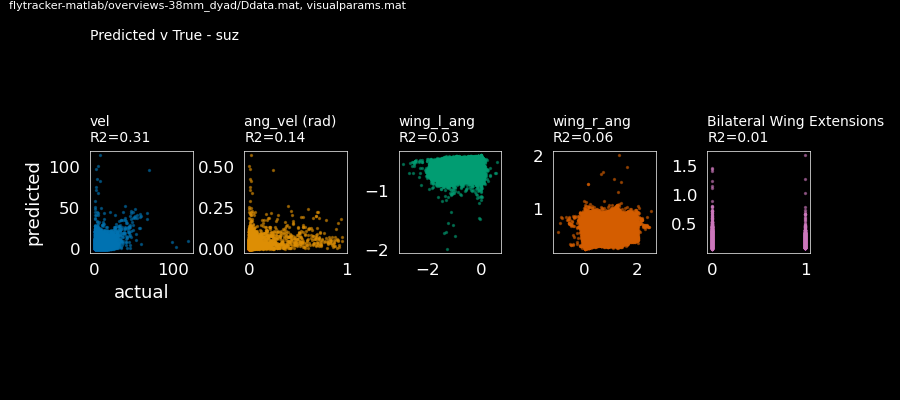

PLSRegression-predicted-v-true_feat_relvel-angsizenorm_suz


In [830]:
yvar_colors = list(sns.color_palette('colorblind', n_colors=len(yvars), as_cmap=False))
fig, axn = pl.subplots(1, len(yvars), figsize=(9,4))
col1 = 'blue'
col2 = 'purple'

yvar_colors = sns.color_palette('colorblind', n_colors=len(yvars))
for i, (var, col) in enumerate(zip(yvars, yvar_colors)):
    ax=axn[i]
    ax.scatter(y_test[:, i], _pred[:, i], color=col, label=var, s=2, alpha=0.5)
    r2_ = r2_score(y_test[:, i], _pred[:, i])
    ax.set_title('{}\nR2={:.2f}'.format(var, r2_), loc='left', fontsize=10)   
    if i==0:
        ax.set_xlabel('actual')
        ax.set_ylabel('predicted')
    ax.set_box_aspect(1)
#ax.legend()

pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9)

fig.text(0.1, 0.9, 'Predicted v True - {}'.format(curr_sp))

putil.label_figure(fig, figid)
figname = '{}-predicted-v-true_feat_{}_{}'.format(model_type, xvar_str, curr_sp)
pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))
print(figname)

In [962]:
xvars = ['Metric Distance', 'Angular Position (norm)', 'Angular Size (norm)', 'Angular Velocity (rad)', 'Target Fly Orientation']
yvars = [ 'Right Wing Extensions', 'Left Wing Extensions', 'Bilateral Wing Extensions', 'Chasing'] #,'Unilateral Wing Extensions'] # 'Metric Relative Velocity (abs)']

allvars = copy.copy(xvars)
allvars.extend(yvars)
inputdata = vp[vp['Disengaged']==0][allvars].dropna().copy()

X = inputdata[xvars]
y = inputdata[yvars]

In [963]:
labels = []
for i, (vi, v) in enumerate(inputdata[yvars].iterrows()):
    if v.sum() == 1:
        if v['Right Wing Extensions'] == 1:
            labels.append('R')
        elif v['Left Wing Extensions'] == 1:
            labels.append('L')
        elif v['Bilateral Wing Extensions'] == 1:
            labels.append('B')
        else: 
            labels.append('C')
    elif v.sum() == 2:
        behavs = v[v==1].index.tolist()
        labels.append( ''.join([s[0] for s in behavs]) )
    else:
        labels.append('N')

In [964]:

X_train, X_test, y_train, y_test = train_test_split( X, labels, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


In [965]:
# Fit the classifier
clf = LogisticRegression() #C=1e5)
clf.fit(X_train, y_train)

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [966]:
ypred = clf.predict(X_test)

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


In [967]:
from sklearn import metrics


<IPython.core.display.Javascript object>


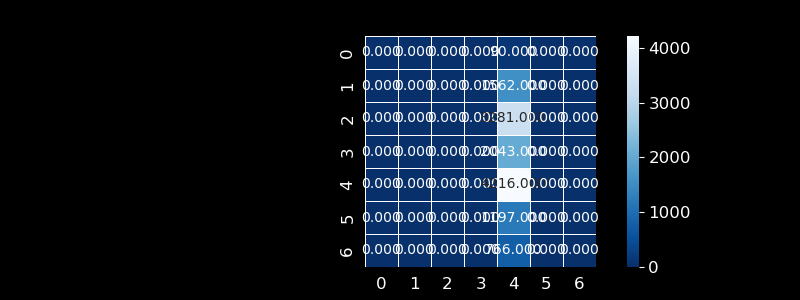

<AxesSubplot:>

In [968]:
fig, ax = pl.subplots(figsize=(8,3)) #pl.figure()
cm = metrics.confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')


In [750]:
ypred.min(), ypred.max()

(0.0, 0.0)

In [815]:
clf.classes_

array(['C', 'L', 'LC', 'N', 'R', 'RC'], dtype='<U2')